# **Irene Dovichi** 
## Midterm 3 - Assignment 3
Train a neural network for sequences of your choice (LSTM, GRU, Convolutional, Clockwork RNN, ...) to predict the Benzene (C6H6 column) based on the sensor measurements timeseries (PT08.* columns) being fed in input to the recurrent model. Evaluate the predictive accuracy of the network on the task (using appropriately training/validation splits).  Confront the perfomance of this model, with another recurrent neural network trained to predict benzene one-step-ahead, i.e. given the current benzene measuement, predict its next value.
Show and compare performance of both settings.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

## Dataset Loading

In [2]:
df = pd.read_csv('air+quality/AirQualityUCI.csv', sep=';', decimal=',', na_values=-200)

In [3]:
# Keep only Date, Time, C6H6, and PT08.* columns
df = df[['Date', 'Time', 'C6H6(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
df.head()

,Date,Time,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
0,10/03/2004,18.00.00,11.9,1360.0,1046.0,1056.0,1692.0,1268.0
1,10/03/2004,19.00.00,9.4,1292.0,955.0,1174.0,1559.0,972.0
2,10/03/2004,20.00.00,9.0,1402.0,939.0,1140.0,1555.0,1074.0
3,10/03/2004,21.00.00,9.2,1376.0,948.0,1092.0,1584.0,1203.0
4,10/03/2004,22.00.00,6.5,1272.0,836.0,1205.0,1490.0,1110.0


In [4]:
df.isna().sum()

Date             114
Time             114
C6H6(GT)         480
PT08.S1(CO)      480
PT08.S2(NMHC)    480
PT08.S3(NOx)     480
PT08.S4(NO2)     480
PT08.S5(O3)      480
dtype: int64

In [5]:
# Drop rows with nan values and reset index
df = df.dropna()
df = df.reset_index(drop=True)
df.isna().sum()

Date             0
Time             0
C6H6(GT)         0
PT08.S1(CO)      0
PT08.S2(NMHC)    0
PT08.S3(NOx)     0
PT08.S4(NO2)     0
PT08.S5(O3)      0
dtype: int64

In [6]:
df.shape

(8991, 8)

In [7]:
# Combine Date and Time columns into a single DateTime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
df = df.drop(columns=['Date', 'Time'])
df.insert(0, 'DateTime', df.pop('DateTime'))

# We notice that df is ordered by DateTime since the min is the first row and the max is the last row
df['DateTime'].min(), df['DateTime'].max()

(Timestamp('2004-03-10 18:00:00'), Timestamp('2005-04-04 14:00:00'))

### Train/Test Split
Since the entire dataset covers more or less a year, we will inevitably have some months in the test set that were not present in the train. Therefore, I decided to do a basic 80/20 split for the train/test and then for the train/val. The only precaution I took was not to mix the instances to maintain temporal sequentiality, and I made sure the sets didn't break a certain day.

In [8]:
# Calculate 80% of length of df
train_size = int(len(df) * 0.8)
train_size

7192

In [9]:
df.iloc[7189:7194]

,DateTime,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
7189,2005-01-15 23:00:00,11.1,1231.0,1017.0,655.0,1207.0,1414.0
7190,2005-01-16 00:00:00,13.6,1289.0,1104.0,623.0,1257.0,1499.0
7191,2005-01-16 01:00:00,9.8,1166.0,970.0,705.0,1136.0,1306.0
7192,2005-01-16 02:00:00,7.6,1062.0,884.0,748.0,1062.0,1172.0
7193,2005-01-16 03:00:00,6.0,1028.0,813.0,794.0,1019.0,1076.0


We can see that, by choosing instance 7189 as the last one for the train, we will get about 80% of the data as train data, and we avoid stopping in the middle of the measurements for a specific day.

In [10]:
train_start_date = df['DateTime'].iloc[0]
train_end_date = df['DateTime'].iloc[7189]

test_start_date = df['DateTime'].iloc[7190]
test_end_date = df['DateTime'].iloc[-1]

train = df[(df['DateTime'] >= train_start_date) & (df['DateTime'] <= train_end_date)]
test = df[(df['DateTime'] >= test_start_date) & (df['DateTime'] <= test_end_date)]

In [11]:
# Calculate 80% of length of train
train_size = int(len(train) * 0.8)
train_size

5752

In [12]:
train.iloc[5759:5764]

,DateTime,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
5759,2004-11-11 21:00:00,16.8,1207.0,1203.0,625.0,1570.0,1251.0
5760,2004-11-11 22:00:00,4.8,904.0,754.0,930.0,1172.0,805.0
5761,2004-11-11 23:00:00,4.0,900.0,711.0,975.0,1153.0,736.0
5762,2004-11-12 00:00:00,4.5,932.0,740.0,926.0,1180.0,774.0
5763,2004-11-12 01:00:00,5.4,968.0,785.0,872.0,1209.0,826.0


In [13]:
train_start_date = train['DateTime'].iloc[0]
train_end_date = train['DateTime'].iloc[5761]

val_start_date = train['DateTime'].iloc[5762]
val_end_date = train['DateTime'].iloc[-1]

train = df[(df['DateTime'] >= train_start_date) & (df['DateTime'] <= train_end_date)]
val = df[(df['DateTime'] >= val_start_date) & (df['DateTime'] <= val_end_date)]

In [14]:
# Just a check that we have a reasonable number of instances
print(f'Wanted instances for train set: {int(len(df) * 0.8 * 0.8)} --> Actual instances: {len(train)}\n'
      f'Wanted instances for val set: {int(len(df) * 0.8 * 0.2)} --> Actual instances: {len(val)}\n'
      f'Wanted instances for test set: {int(len(df) * 0.2)} --> Actual instances: {len(test)}')

Wanted instances for train set: 5754 --> Actual instances: 5762
Wanted instances for val set: 1438 --> Actual instances: 1428
Wanted instances for test set: 1798 --> Actual instances: 1801


## Sensors Based Model
For the first task we select the columns of sensor measurements as input features, and Benzene as target.

In [15]:
X_train = train[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
y_train = train['C6H6(GT)']

X_val = val[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
y_val = val['C6H6(GT)']

X_test = test[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
y_test = test['C6H6(GT)']

### Scaling
As for scaling, I decided to use `MinMaxScaler()` to keep the features in a range of [0,1] but maintaining their distributions.

In [17]:
# Scale X values
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Scale y values
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

### Reshaping
I am going to use a LSTM layer, which requires the data to be in the form: `[samples, timesteps, features]`. I am going to add a new dimension to the data: `timesteps = 1`, since each input sample is a single timestep of 5 features (the PT08.* columns).

In [18]:
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

### Vanilla LSTM Model
Let's try a simple model: 1 LSTM layer with 10 units. The summary tells us that the LSTM layer has 640 parameters; in fact, it takes as input vectors of size *_m_*=5 and returns as output vectors of size *_n_*=10, and the number of parameters is $4(nm + n^2 + n)$.

In [19]:
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))  
model.add(LSTM(10, activation='relu', return_sequences=False))  
model.add(Dense(1))  

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651 (2.54 KB)

 Trainable params: 651 (2.54 KB)

 Non-trainable params: 0 (0.00 B)

#### Training Phase

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 879us/step - loss: 0.0209 - val_loss: 0.0058
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 0.0020 - val_loss: 0.0038
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 0.0013 - val_loss: 0.0033
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 0.0011 - val_loss: 0.0029
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 9.1258e-04 - val_loss: 0.0026
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 7.8626e-04 - val_loss: 0.0024
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 6.8321e-04 - val_loss: 0.0022
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 5.9738e-04 - val_loss: 0.0020
Epoch 9/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 5.2412e-04 - val_loss: 0.0018
Epoch 10/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 4.6155e-04 - val_loss: 0.0016
Epoch 11/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 4.0761e-04 - val_loss

Test Loss: 2.021295586018823e-05



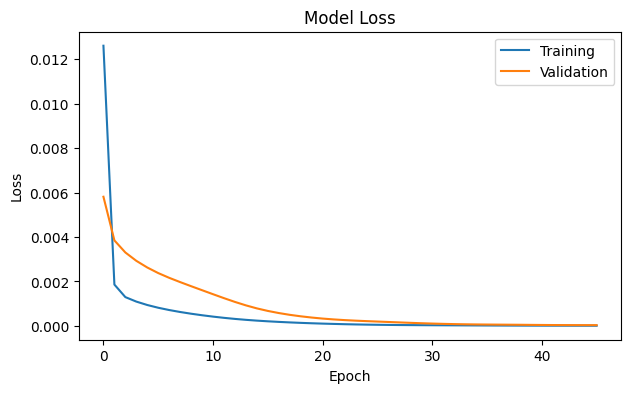

In [21]:
# Print test loss and accuracy
loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f'Test Loss: {loss}\n')

history = history.history

# Plot training & validation loss 
plt.figure(figsize=(7, 4))
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Predictions

In [22]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred_scaled = y_pred_scaled.reshape(-1, 1)

y_pred = y_scaler.inverse_transform(y_pred_scaled)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [23]:
y_test.shape, y_pred.shape

((1801,), (1801, 1))

In [24]:
y_test = y_test.values.reshape(-1, 1)
y_test.shape

(1801, 1)

In [25]:
mse = mean_squared_error(y_test, y_pred)
print(f'MSE between y_test and y_pred: {mse.round(4)}')

r2 = r2_score(y_test, y_pred)
print(f'R2 between y_test and y_pred: {r2.round(4)}')

MSE between y_test and y_pred: 0.0542
R2 between y_test and y_pred: 0.9987


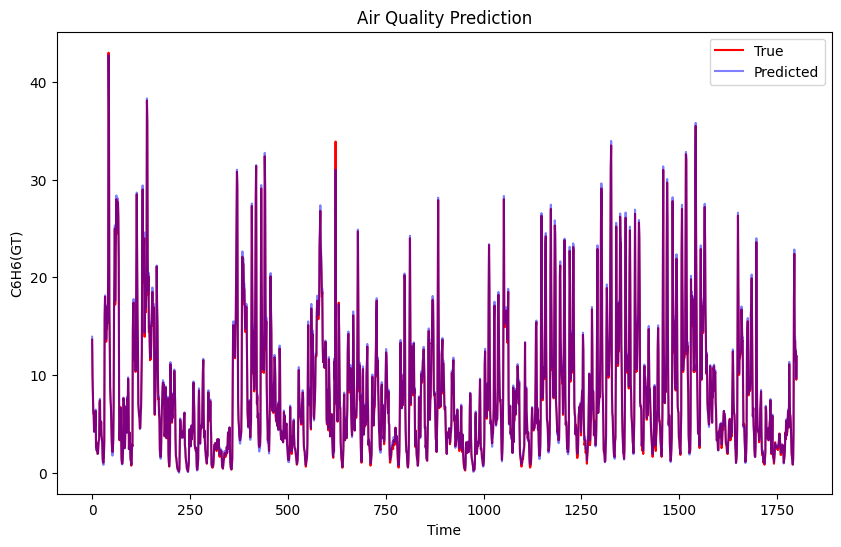

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, color='red', label='True')
plt.plot(y_pred, color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

From the plot above we can deduce that the test set is predicted satisfactorily, even if in the Time interval [500:750] the real time series makes a peak which is only partially predicted: you can see a red piece not "covered" by the blue plot. Let's see this region better. 

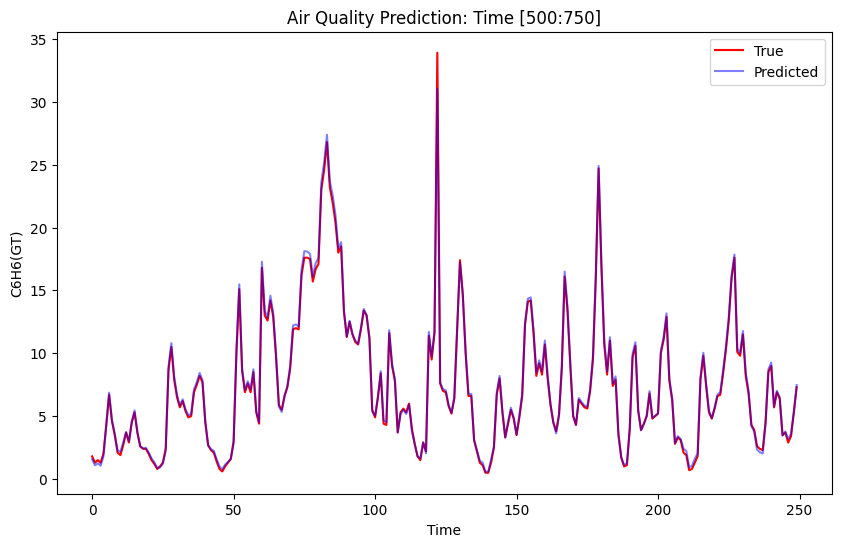

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[500:750], color='red', label='True')
plt.plot(y_pred[500:750], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction: Time [500:750]')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

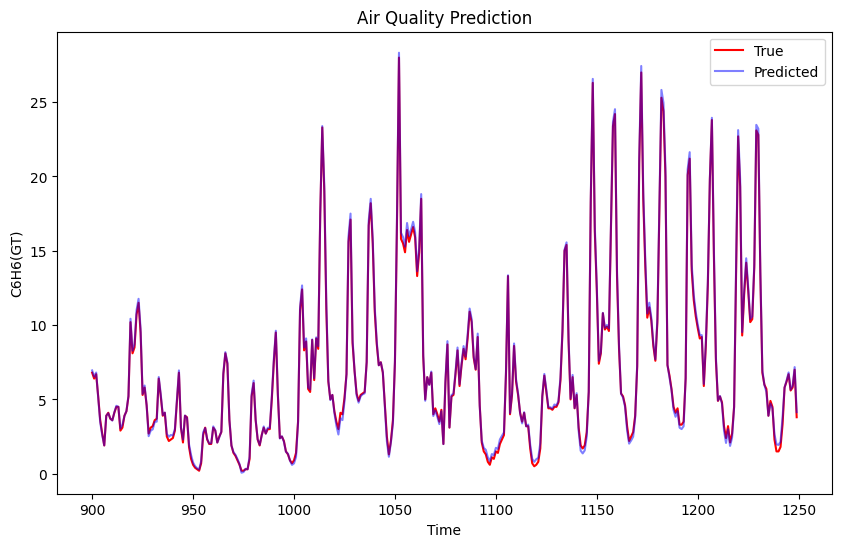

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[900:1250], color='red', label='True')
plt.plot(y_pred[900:1250], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction')
plt.ylabel('C6H6(GT)')
plt.xticks(range(0, 1250-900+1, 50), range(900, 1251, 50))
plt.xlabel('Time')
plt.legend()
plt.show()

### Stacked LSTM Model
Let's try with a stacked LSTM model

In [110]:
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))  # Input layer
model.add(LSTM(50, activation='relu', return_sequences=True)) 
model.add(LSTM(50, activation='relu', return_sequences=True)) 
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dense(1))  

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 1, 50)          │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 1, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,651 (201.76 KB)

 Trainable params: 51,651 (201.76 KB)

 Non-trainable params: 0 (0.00 B)

#### Training Phase

In [111]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0293 - val_loss: 0.0018
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 0.0011 - val_loss: 0.0014
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 9.2241e-04 - val_loss: 0.0013
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 8.0310e-04 - val_loss: 0.0012
Epoch 9/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 6.8161e-04 - val_loss: 0.0012
Epoch 10/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 5.6378e-04 - val_loss: 0.0012
Epoch 11/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 4.4674e-04 - val_loss: 0.0010
E

Test Loss: 1.448066541342996e-05



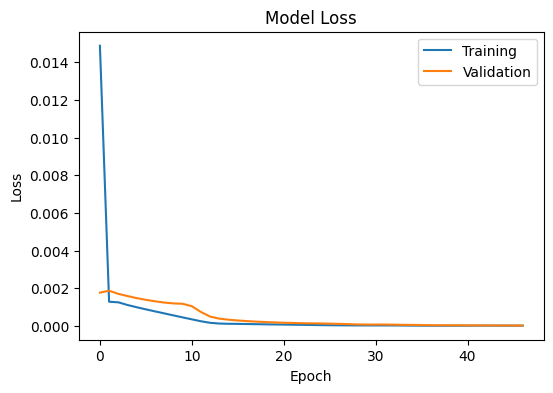

In [112]:
# Print test loss and accuracy
loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f'Test Loss: {loss}\n')

history = history.history

# Plot training & validation loss 
plt.figure(figsize=(6, 4))
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Predictions

In [113]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred_scaled = y_pred_scaled.reshape(-1, 1)

y_pred = y_scaler.inverse_transform(y_pred_scaled)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [114]:
mse = mean_squared_error(y_test, y_pred)
print(f'MSE between y_test and y_pred: {mse.round(4)}')

MSE between y_test and y_pred: 0.0389


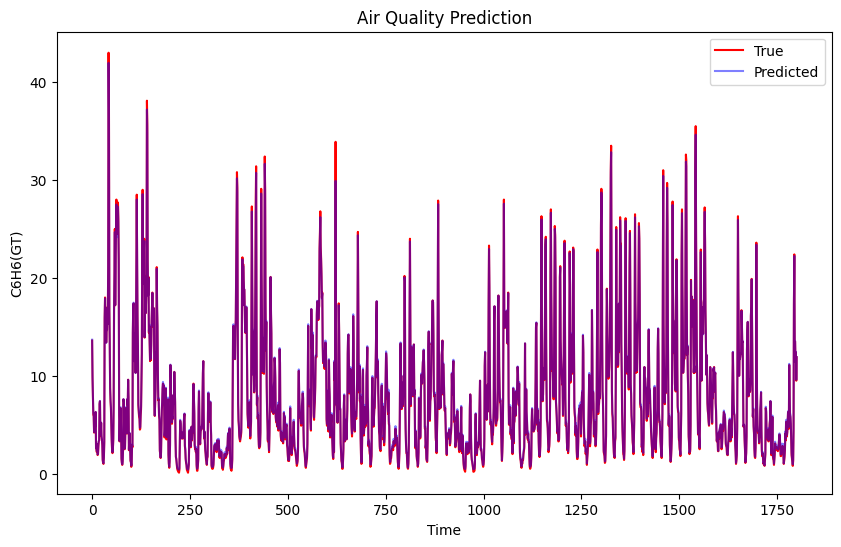

In [115]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, color='red', label='True')
plt.plot(y_pred, color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

We can notice that the the pick between times 100-150 is now predicted pretty well, better with respect to the previous (vanilla) model!

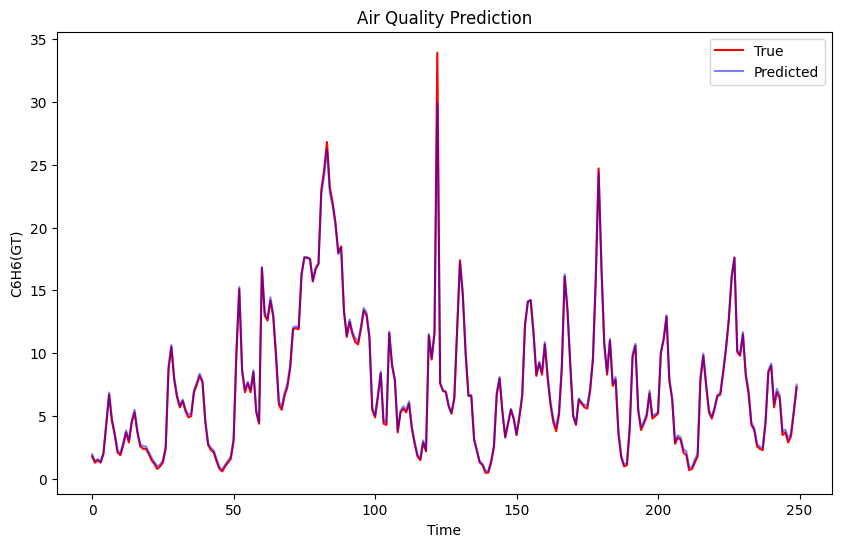

In [116]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[500:750], color='red', label='True')
plt.plot(y_pred[500:750], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

Moreover, the predictions are better also between times `???.` In the vanilla model we could notice that the predictions were lower than the true values

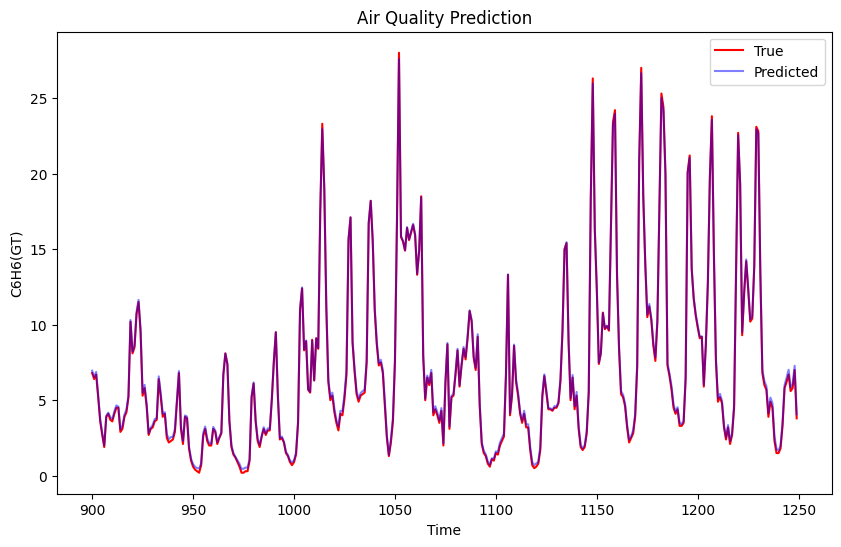

In [117]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[900:1250], color='red', label='True')
plt.plot(y_pred[900:1250], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction')
plt.ylabel('C6H6(GT)')
plt.xticks(range(0, 1250-900+1, 50), range(900, 1251, 50))
plt.xlabel('Time')
plt.legend()
plt.show()

## One-step ahead Model

In [43]:
# We have already split the data into train, val, and test sets paying attention to the order of the instances
train.shape, val.shape, test.shape

((5762, 7), (1428, 7), (1801, 7))

In [44]:
# Keep only the Benzene column
train_B = train[['C6H6(GT)']]
val_B = val[['C6H6(GT)']]
test_B = test[['C6H6(GT)']]

type(train_B), type(val_B), type(test_B)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [45]:
# The target of each Benzene prediction is the next Benzene value
def prepare_data(data):
    X = data[:-1]
    y = data[1:]
    return X, y

In [46]:
# Let the DataFrames become numpy arrays
train_B = train_B.to_numpy()
val_B = val_B.to_numpy()
test_B = test_B.to_numpy()

# Let's prepare the data
X_train_seq, y_train_seq = prepare_data(train_B)
X_val_seq, y_val_seq = prepare_data(val_B)
X_test_seq, y_test_seq = prepare_data(test_B)

In [47]:
X_train_seq.shape, y_train_seq.shape, X_val_seq.shape, y_val_seq.shape, X_test_seq.shape, y_test_seq.shape

((5761, 1), (5761, 1), (1427, 1), (1427, 1), (1800, 1), (1800, 1))

### Scaling

In [48]:
X_train_seq.min(), X_train_seq.max(), y_train_seq.min(), y_train_seq.max()

(0.3, 52.1, 0.3, 52.1)

In [49]:
# Scale X values
scaler = MinMaxScaler()
X_train_seq_scaled = scaler.fit_transform(X_train_seq)
X_val_seq_scaled = scaler.transform(X_val_seq)
X_test_seq_scaled = scaler.transform(X_test_seq)

# Scale y values with the same scaler used for X values
y_train_seq_scaled = scaler.transform(y_train_seq)
y_val_seq_scaled = scaler.transform(y_val_seq)
y_test_seq_scaled = scaler.transform(y_test_seq)

### Reshaping

In [50]:
X_train_seq_scaled = X_train_seq_scaled.reshape((X_train_seq_scaled.shape[0], 1, X_train_seq_scaled.shape[1]))
X_val_seq_scaled = X_val_seq_scaled.reshape((X_val_seq_scaled.shape[0], 1, X_val_seq_scaled.shape[1]))
X_test_seq_scaled = X_test_seq_scaled.reshape((X_test_seq_scaled.shape[0], 1, X_test_seq_scaled.shape[1]))

In [51]:
print(X_train_seq_scaled.shape, y_train_seq_scaled.shape)
print(X_val_seq_scaled.shape, y_val_seq_scaled.shape)
print(X_test_seq_scaled.shape, y_test_seq_scaled.shape)

(5761, 1, 1) (5761, 1)
(1427, 1, 1) (1427, 1)
(1800, 1, 1) (1800, 1)


### Vanilla LSTM Model

In [52]:
# Vanilla LSTM model: 1 layer with 10 units
model = Sequential()
model.add(Input(shape=(X_train_seq_scaled.shape[1], X_train_seq_scaled.shape[2])))  # Input layer
model.add(LSTM(10, activation='relu', return_sequences=True))  
model.add(Dense(1))  

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 1, 10)          │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1, 1)           │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

#### Training Phase

In [53]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, restore_best_weights=True)
history = model.fit(X_train_seq_scaled, y_train_seq_scaled, epochs=100, batch_size=32, validation_data=(X_val_seq_scaled, y_val_seq_scaled), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - loss: 0.0454 - val_loss: 0.0260
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 0.0181 - val_loss: 0.0225
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 0.0169 - val_loss: 0.0211
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 0.0160 - val_loss: 0.0194
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 0.0148 - val_loss: 0.0173
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 0.0134 - val_loss: 0.0151
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 0.0120 - val_loss: 0.0129
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 0.0105 - val_loss: 0.0109
Epoch 9/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 0.0093 - val_loss: 0.0093
Epoch 10/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 0.0083 - val_loss: 0.0082
Epoch 11/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 0.0077 - val_loss: 0.0075
Epoch 12/100
181/18

Test Loss: 0.00527094304561615



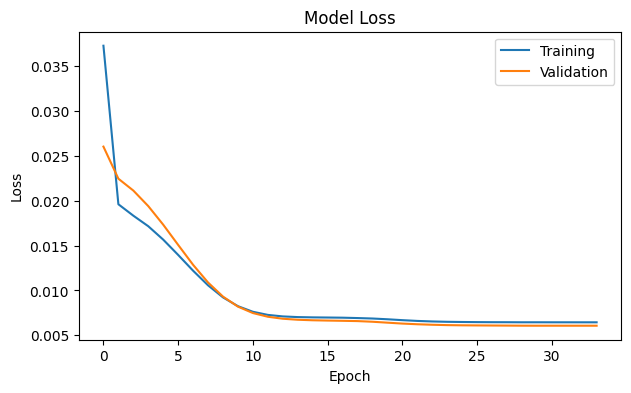

In [54]:
# Print test loss and accuracy
loss = model.evaluate(X_test_seq_scaled, y_test_seq_scaled, verbose=0)
print(f'Test Loss: {loss}\n')

history = history.history

# Plot training & validation loss 
plt.figure(figsize=(7, 4))
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Predictions

In [55]:
y_pred_seq_scaled = model.predict(X_test_seq_scaled)
y_pred_seq_scaled = y_pred_seq_scaled.reshape(-1, 1)

y_pred_seq = scaler.inverse_transform(y_pred_seq_scaled) 

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [56]:
y_test_seq.shape, y_pred_seq.shape

((1800, 1), (1800, 1))

In [57]:
mse = mean_squared_error(y_test_seq, y_pred_seq)
print(f'MSE between y_test_seq and y_pred_seq: {mse.round(4)}')

MSE between y_test_seq and y_pred_seq: 14.1432


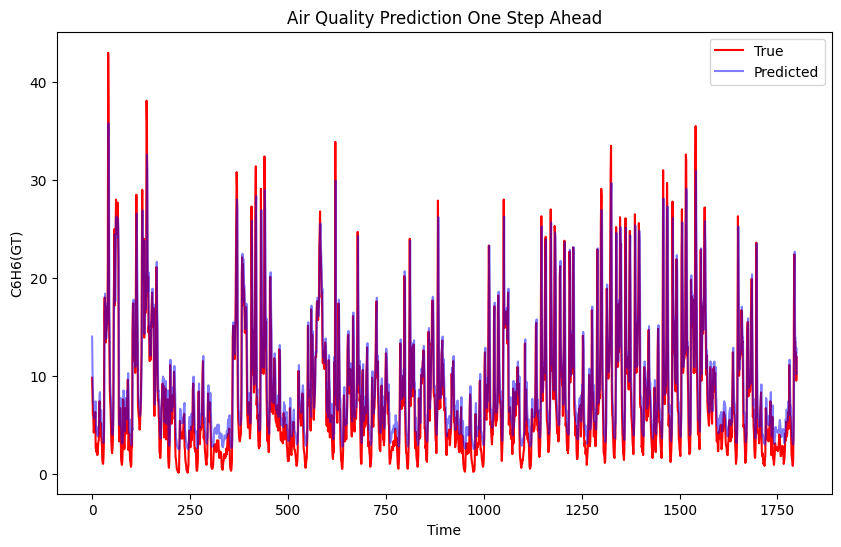

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, color='red', label='True')
plt.plot(y_pred_seq, color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction One Step Ahead')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

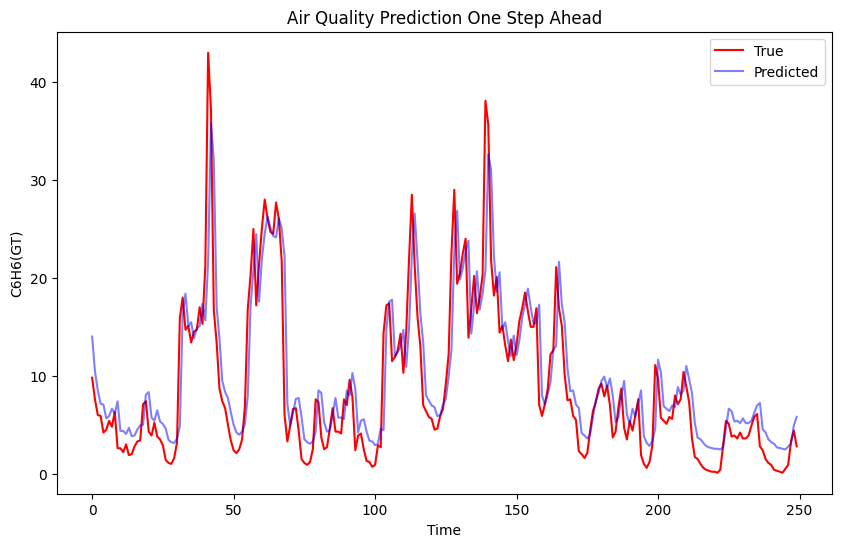

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq[:250], color='red', label='True')
plt.plot(y_pred_seq[:250], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction One Step Ahead')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

### Stacked LSTM Model

In [60]:
model = Sequential()
model.add(Input(shape=(X_train_seq_scaled.shape[1], X_train_seq_scaled.shape[2])))  # Input layer
model.add(LSTM(50, activation='relu', return_sequences=True))  
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dense(1))  

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 1, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 1, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

#### Training Phase

In [61]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, restore_best_weights=True)
history = model.fit(X_train_seq_scaled, y_train_seq_scaled, epochs=100, batch_size=32, validation_data=(X_val_seq_scaled, y_val_seq_scaled), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0339 - val_loss: 0.0230
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 0.0136 - val_loss: 0.0096
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 0.0081 - val_loss: 0.0083
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 0.0076 - val_loss: 0.0074
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 0.0071 - val_loss: 0.0064
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 0.0066 - val_loss: 0.0060
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 0.0064 - val_loss: 0.0059
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 0.0064 - val_loss: 0.0059
Epoch 9/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 0.0064 - val_loss: 0.0059
Epoch 10/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 0.0064 - val_loss: 0.0059
Epoch 11/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 0.0064 - val_loss: 0.0059
Epoch 12/100
181/181 

Test Loss: 0.0049097733572125435



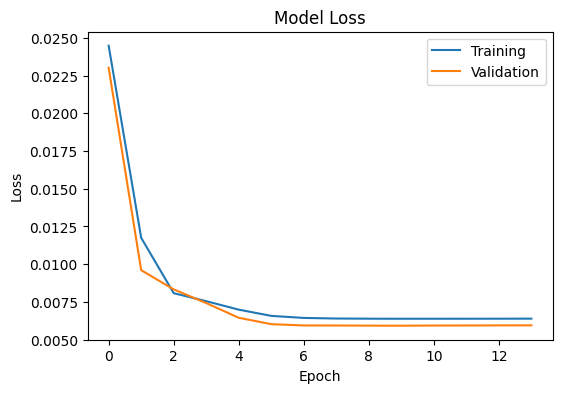

In [62]:
# Print test loss and accuracy
loss = model.evaluate(X_test_seq_scaled, y_test_seq_scaled, verbose=0)
print(f'Test Loss: {loss}\n')

history = history.history

# Plot training & validation loss
plt.figure(figsize=(6, 4))
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Predictions

In [63]:
# Predict y values
y_pred_seq_scaled = model.predict(X_test_seq_scaled)
y_pred_seq_scaled = y_pred_seq_scaled.reshape(-1, 1)

y_pred_seq = scaler.inverse_transform(y_pred_seq_scaled)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [64]:
mse = mean_squared_error(y_test_seq, y_pred_seq)
print(f'MSE between y_test_seq and y_pred_seq: {mse.round(4)}')

MSE between y_test_seq and y_pred_seq: 13.1741


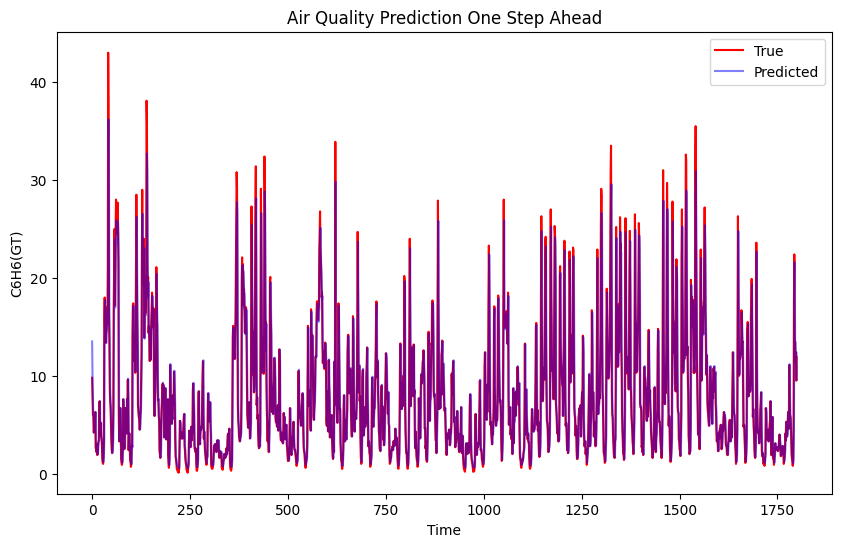

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, color='red', label='True')
plt.plot(y_pred_seq, color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction One Step Ahead')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

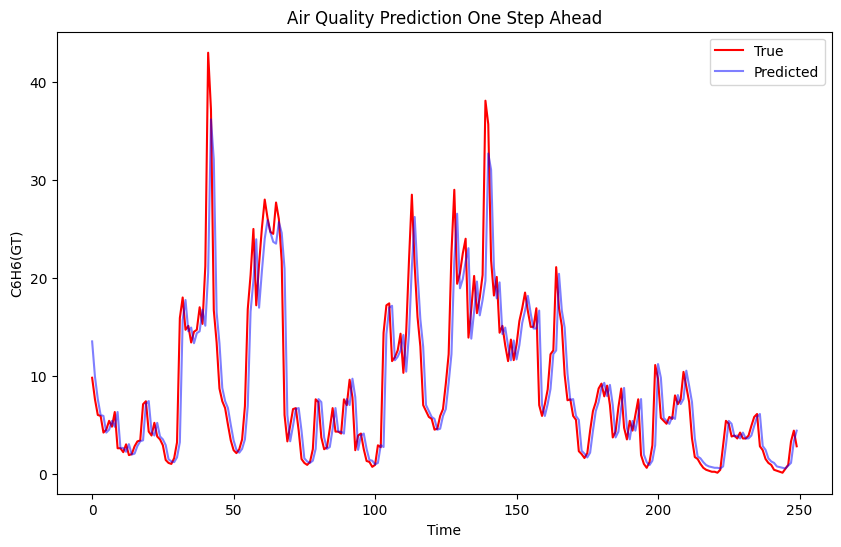

In [76]:
# plot a zoomed-in version of the plot above
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq[:250], color='red', label='True')
plt.plot(y_pred_seq[:250], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction One Step Ahead')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

In [ ]:
#TODO: try to increase complexity of the model and reach same performances as in the stacked LSTM model

## Personal Considerations

In [67]:
# see the correlation between the features of df and the target C6H6(GT)
df.corr()['C6H6(GT)']

DateTime        -0.064292
C6H6(GT)         1.000000
PT08.S1(CO)      0.883795
PT08.S2(NMHC)    0.981950
PT08.S3(NOx)    -0.735744
PT08.S4(NO2)     0.765731
PT08.S5(O3)      0.865689
Name: C6H6(GT), dtype: float64

In [56]:
# il dropout nel primo modello rendeva le performances peggiori: forse perchè il modello era troppo semplice e il dropout lo rendeva ancora più semplice

In [ ]:
# I also tried a CNN model (I didn't keep the results in the notebook) but it performed analogously than the LSTM models. In that case too the use of dropout made the performances worse. 

In [ ]:
# 1. Model Perfromance Metrics: MSE and R^2
# 2. Model Complexity (even though the training was fast in both cases)
# 3. Feature Relevance: Directly using sensor data may leverage more meaningful features related to benzene concentration. The one-step-ahead model relies on the assumption that the previous benzene value is a good predictor of the next, which may not always capture underlying patterns as effectively. This is confirmed by the correlations between the features and the target. 

In [ ]:
'''
R² = 0.75: This means that 75% of the variability in benzene concentration can be explained by 
the sensor readings in your model. This suggests a reasonably good fit, but there might still be
 some unexplained variance due to other factors or noise.

Overfitting: A very high R² on the training data might indicate overfitting, especially if the 
model performs poorly on validation or test data.
HOWEVER, the performances on validation and test data are good, so we can say that the model is not overfitting.
'''